# Using Legacy Survey imaging (demo)

In [1]:
from fastai import *
from fastai.vision import *

%matplotlib inline

PATH = os.path.abspath('..')

seed = 12345

In [2]:
sys.path.append(f'{PATH}/src')
from ranger import Ranger

In [3]:
import fastai
fastai.__version__

'1.0.57'

# Simple convnet

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, pretrained=False):                 
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(128*14*14, 1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out



In [5]:
df_xgass = pd.read_csv(f'{PATH}/data/xGASS_representative_sample.csv')
df_xgass['logfgas'] = df_xgass.lgMHI - df_xgass.lgMstar

df_xgass.sample(3)

,GASS,AGCnr,SDSS,PLATEID,MJD,FIBERID,RA,DEC,zSDSS,Dlum,...,HIconf_flag,weight,group_id_B,NYU_id,env_code_B,Ngal_B,yang_shred_code,logMh_Mst_B,lvir_ratB,logfgas
1113,11314,332471,J231224.51+135704.5,744,52251,240,348.10217,13.95128,0.034120,149.9,...,1.0,0.634,11254,348019,0,3,0,12.9082,-1.167304,-0.810000
1102,11071,320866,J225726.69+130005.9,741,52261,55,344.36124,13.00165,0.025680,112.1,...,0.0,0.634,1412,721620,0,12,0,13.1901,-0.459056,-1.553000
802,113011,743779,J135906.39+175604.9,2756,54508,65,209.77664,17.93471,0.017569,76.3,...,0.0,2.294,449806,2361671,1,1,0,0.0000,-99.000000,0.058916


In [6]:
bs = 64
sz = 224

xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]
tfms = get_transforms(do_flip=True, flip_vert=True, max_zoom=1., max_rotate=15., max_lighting=0, max_warp=0)


In [8]:
src = (ImageList.from_df(df_xgass, path=PATH, folder='images-xgass-legacy', suffix='.jpg', cols='GASS')
                .split_by_rand_pct(0.2, seed=seed)
                .label_from_df(cols=['logfgas'],  label_cls=FloatList)
      )

data = (src.transform(tfms, size=sz)
            .databunch(bs=bs)
            .normalize(xGASS_stats)
       )

In [9]:
learn = Learner(data, model=SimpleCNN(), 
                opt_func=partial(Ranger),
                loss_func=root_mean_squared_error,
                wd=1e-3, bn_wd=False, true_wd=True,
               )


# Training

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


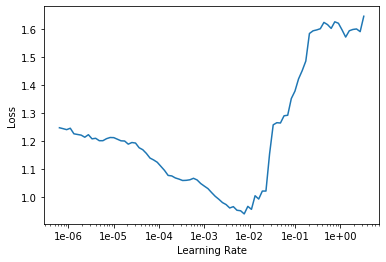

In [50]:
learn.lr_find()
learn.recorder.plot()

In [54]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,time
0,0.734198,0.875695,01:12
1,0.688983,0.734803,01:14
2,0.628072,0.730990,01:14
3,0.596866,0.511896,01:14
4,0.562138,0.469071,01:14
5,0.542625,0.485717,01:13
6,0.510004,0.438570,01:14
7,0.489998,0.424811,2:06:32
8,0.470193,0.420261,01:14
9,0.455295,0.419389,01:13


In [10]:
# learn.save('simplecnn-10ep_sz224-bs64');
learn.load('simplecnn-10ep_sz224-bs64');

set state called


# xresnet9

In [ ]:
xresnet9 = partial(models.xresnet.xresnet, expansion=1, n_layers=[1, 1, 1, 1], name='xresnet9')

In [ ]:
learn = Learner(data, model=xresnet9(), 
                opt_func=partial(Ranger),
                loss_func=root_mean_squared_error,
                wd=1e-3, bn_wd=False, true_wd=True,
               )

learn.model[-1] = nn.Linear(512, 1, bias=True)
